In [18]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
from sklearn import metrics

The shape of the digits dataset:
(1797, 64)


<Figure size 432x288 with 0 Axes>

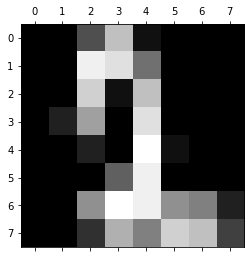

[0]
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [3]:
digits=load_digits()
X = digits.data
print("The shape of the digits dataset:") 
print(digits.data.shape)
plt.gray()
plt.matshow(digits.images[12])
plt.show()
y = digits.target
print(y[0:1])
print(X[0,:])

In [4]:
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

X[0,:] # Looking the new features after scaling
X.shape 

(1797, 64)

In [5]:
#Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1078, 64)
(719, 64)
(1078,)
(719,)


In [6]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [7]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

In [8]:
print(y_train[0:4])
print(y_v_train[0:4])

[5 3 3 1]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
def f(z):
    return 1 / (1 + np.exp(-z))
    #return np.maximum(0,z) #ReLU
    #return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z)) #tanh


def f_deriv(z):
    return f(z) * (1 - f(z))
    #return np.greater(z, 0).astype(int) #ReLU
    #return 1-(np.square(f(z))) #tanh

In [10]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [11]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [12]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [13]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [14]:
def train_nn(nn_structure, X, y, iter_num=5000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    N = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(N):
            delta = {}
            # perform the feed forward pass and return the stored a and z values, to be used in the
            # gradient descent step
            a, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-a[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            #W[l] += -alpha * (1.0/N * tri_W[l])
            W[l] += -alpha * (1.0/N * tri_W[l] + 0.001 * W[l]) #regularization
            b[l] += -alpha * (1.0/N * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/N * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [15]:
nn_structure = [64, 40, 10]

# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


In [16]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 91.51599443671766%


In [19]:
print(metrics.classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        74
           1       0.88      0.82      0.85        78
           2       0.96      0.92      0.94        72
           3       0.95      0.92      0.94        64
           4       0.97      0.90      0.93        63
           5       0.89      0.97      0.93        73
           6       0.99      0.94      0.96        77
           7       0.91      0.97      0.94        66
           8       0.76      0.89      0.82        76
           9       0.94      0.84      0.89        76

    accuracy                           0.92       719
   macro avg       0.92      0.92      0.92       719
weighted avg       0.92      0.92      0.92       719

